In [109]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import IncrementalPCA
import sklearn.metrics as skm

from src.data.preprocess_templates import *

In [12]:
repo_dir = "/Users/johnzhou/research/spike-sorting"
cluster_templates = np.load(f"{repo_dir}/data/processed/clusters_k=20/templates.npy")
cluster_labels = np.load(f"{repo_dir}/data/processed/clusters_k=20/unit_idxs.npy")
featurize_templates = np.load(f"{repo_dir}/data/processed/featurization_train/templates.npy")

geom_array = np.load(f"{repo_dir}/data/raw/channel_map_np2.npy")
channels_pos = geom_array[:20]

In [167]:
raw_10s = np.load(f"{repo_dir}/data/raw/ten_np2_seconds.npy")
raw_10s = np.expand_dims(raw_10s, axis=0)
print(raw_10s.shape)

(1, 300000, 384)


0


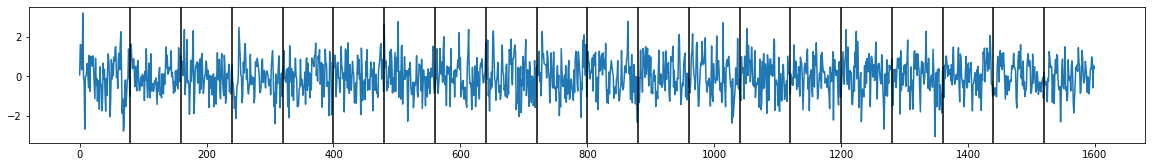

In [185]:
raw_max_chan_temps = np.array([192])
plot_templates(raw_10s[:, :170, :], raw_max_chan_temps)

In [10]:
num_latents = 6
num_samples, num_timesteps, num_channels = featurize_templates.shape
templates_flat = np.reshape(featurize_templates, (num_samples, num_timesteps * num_channels))
ipca = IncrementalPCA(n_components=num_latents)
ipca.partial_fit(templates_flat)

In [25]:
# Preprocess cluster templates
print(cluster_templates.shape)
cluster_templates = np.swapaxes(cluster_templates, 1, 2)
a, loc, scale = 3, 100, 500
n_channels = 20
max_chan_temp = get_max_chan_temps(cluster_templates)
cluster_chans, cluster_ptp_chans = take_channel_range(cluster_templates, n_channels_loc=n_channels)

(2000, 384, 121)


In [26]:
print(featurize_templates.shape)
cluster_chans = np.swapaxes(cluster_chans, 1, 2)
print(cluster_chans.shape)
num_samples, num_timesteps, num_channels = cluster_chans.shape
cluster_templates_flat = np.reshape(cluster_chans, (num_samples, num_timesteps * num_channels))
latent_rep = ipca.transform(cluster_templates_flat)

(80000, 20, 121)
(2000, 20, 121)


In [107]:
cluster_unique, unique_idxs = np.unique(cluster_labels, return_index=True)
idx_bounds = np.sort(unique_idxs)[1:]
clusters = np.split(cluster_labels, idx_bounds)
clusters = np.vsplit(latent_rep, idx_bounds)
print([cluster.shape for cluster in clusters])
print(len([cluster.shape for cluster in clusters]))

[(100, 6), (100, 6), (100, 6), (100, 6), (100, 6), (100, 6), (100, 6), (100, 6), (100, 6), (100, 6), (100, 6), (100, 6), (100, 6), (100, 6), (100, 6), (100, 6), (100, 6), (100, 6), (100, 6), (100, 6)]
20


In [128]:
from scipy.spatial.distance import cdist

num_clusters = len(clusters)
neg_conf_matrix = np.zeros((num_clusters, num_clusters))
eval_metric = 'l2'

for i, cluster_a in enumerate(clusters):
    for j, cluster_b in enumerate(clusters):
        inter_cluster_dists = pairwise_distances(cluster_a, cluster_b, metric=eval_metric)
        avg_inter_cluster_dist = np.mean(inter_cluster_dists)
        neg_conf_matrix[i, j] = avg_inter_cluster_dist
        neg_conf_matrix[j, i] = avg_inter_cluster_dist

avg_intra_cluster_dists = np.mean(np.diagonal(neg_conf_matrix))
neg_conf_matrix /= avg_intra_cluster_dists

min_dist = np.min(neg_conf_matrix, axis=0)
rearrange = np.argsort(min_dist)
neg_conf_matrix = neg_conf_matrix[rearrange, :]
neg_conf_matrix = neg_conf_matrix[:, rearrange]
print("min:", np.min(neg_conf_matrix), "max:", np.max(neg_conf_matrix), 
      "median:", np.median(neg_conf_matrix), "mean:", np.mean(neg_conf_matrix))

1.7079448768187266
min: 0.15223408884593592 max: 24.429213474173128 median: 2.729545036384413 mean: 4.611515103773334
(20,)
[0.32646042 1.20430959 6.61642205 0.18244379 1.08721415 0.6812358
 1.12514191 0.74604121 0.89687486 0.92971159 0.91056382 0.66647135
 0.2790853  0.86696806 1.70412741 0.42886313 0.25777875 0.15223409
 0.68072789 0.25732482]
min: 0.15223408884593592 max: 24.429213474173128 median: 2.729545036384413 mean: 4.611515103773334
1.0
(20, 20)


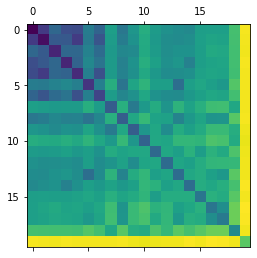

In [129]:
plt.matshow(np.log(neg_conf_matrix))

/Users/johnzhou/anaconda3/envs/yass/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


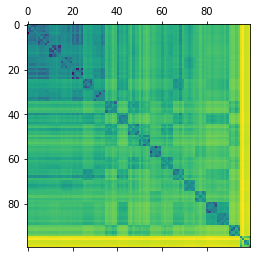

In [161]:
import math
five_from_each = [cluster[:5, :] for cluster in clusters]
five_from_each = np.stack(five_from_each)
# Sort by same min dist as clusters
five_from_each = np.reshape(five_from_each[rearrange, :, :], (100, 6))
fives_neg_conf_matrix = pairwise_distances(five_from_each, metric=eval_metric)
log_matrix = np.log(fives_neg_conf_matrix)
log_matrix[np.where(np.isneginf(log_matrix))] = 0
plt.matshow(log_matrix)